# Fiddle with the EAWAG scans
Look at the orientation and see if we can do some cropping based on landmarks.

In [1]:
# If you are running this notebook in Google Colab, then uncomment and run the line below
# !pip install k3d matplotlib-scalebar dask-image numcodecs zarr
# from google.colab import output
# output.enable_custom_widget_manager()

In [2]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import scipy
import k3d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
import skimage
from tqdm.auto import tqdm, trange
import math
from numcodecs import Blosc
from skimage.segmentation import random_walker

In [3]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to F:\tmp


In [4]:
from dask.distributed import Client
client = Client()

C:\Users\haberthu\Miniconda3\envs\eawag\lib\site-packages\distributed\node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60524 instead
  warnings.warn(


In [5]:
client

<Client: 'tcp://127.0.0.1:60525' processes=8 threads=32, memory=255.70 GiB>

In [6]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:60524/status"


In [7]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [8]:
# Set seaborn theme
seaborn.set_theme(context='notebook', style='ticks')
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [9]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [10]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [11]:
# Different locations if running either on Linux or Windows
FastSSD = True
overthere = False  # Load the data directly from the iee-research_storage drive
nanoct = True  # Load the data directly from the 2214
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    elif overthere:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-iee')
    elif nanoct:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
if not overthere:
    Root = os.path.join(BasePath, 'EAWAG')
else:
    Root = BasePath
# if overthere:
#         Root = os.path.join('I:\\microCTupload')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\EAWAG


In [12]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [13]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [14]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [15]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [16]:
# Get *all* log files, unsorted but fast
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [17]:
# Adapted from zmk-tooth-cohort/ToothAnalysis.ipynb
if not len(Data):
    # Our dataframe is empty.
    # We might be running on Binder, i.e. offer to download some sample data :)
    import requests
    # Inform user
    print('You are most probably running the notebook on binder and thus do not have access to the data files.')
    print('We are downloading and unpacking *one* cichlid head scan from https://osf.io/8vjxc/')
    print('The data file is approximately 500 MB big, so this will take a while.')
    # Change root folder
    Root = 'data'
    os.makedirs(Root, exist_ok=True)
    # Download from osf.io
    filelist = ['https://files.de-1.osf.io/v1/resources/8vjxc/providers/osfstorage/63d3bfa83c39ad005f30d024/?zip=']
    fishlist = ['104016']
    for c, file in enumerate(filelist):
        os.makedirs(os.path.join(Root, fishlist[c]), exist_ok=True)
        if os.path.exists(os.path.join(Root, fishlist[c], fishlist[c] + '.zip')):
            print('ZIP file for %s was already downloaded' % fishlist[c])
        else:
            # Progress bar for download: https://github.com/tqdm/tqdm/blob/master/examples/tqdm_requests.py
            # via https://stackoverflow.com/questions/43743438/using-tqdm-to-add-a-progress-bar-when-downloading-files/44920494#comment118687934_44920494
            response = requests.get(filelist[c], stream=True)
            with open(os.path.join(Root, fishlist[c], fishlist[c] + '.zip'), "wb") as fout:
                with tqdm(unit='B',
                          unit_scale=True,
                          unit_divisor=1024,
                          miniters=1,
                          desc=fishlist[c] + '.zip',
                          total=int(response.headers.get('content-length', 0))) as pbar:
                    for chunk in response.iter_content(chunk_size=4096):
                        fout.write(chunk)
                        pbar.update(len(chunk))
    # Unzip the files
    import zipfile
    ziplist = glob.glob(os.path.join(Root, '**', '*.zip'))
    for downloaded_file in tqdm(ziplist,
                                total=len(ziplist),
                                desc='Unzipping %s files' % len(ziplist)):
        with zipfile.ZipFile(downloaded_file, 'r') as zip_file:
            # print(zip_file.namelist())
            for filename in tqdm(iterable=zip_file.namelist(),
                                 desc=downloaded_file,
                                 total=len(zip_file.namelist()),
                                 leave=False):
                if not os.path.exists(os.path.join(Root, fishlist[c], filename)):
                    zip_file.extract(member=filename, path=os.path.join(Root, fishlist[c]))
    # Search for log files again
    Data['LogFile'] = [os.path.join(root, name)
                       for root, dirs, files in os.walk(Root)
                       for name in files
                       if name.endswith((".log"))]

In [18]:
print('We found %s log files in %s' % (len(Data), Root))

We found 5 log files in F:\EAWAG


In [19]:
# Limit *all* the data to only the 'head' scans
Data = Data[Data['LogFile'].str.contains('head')]

In [20]:
print('We have %s log files with "head" in their name in %s' % ((len(Data)), Root))

We have 5 log files with "head" in their name in F:\EAWAG


In [21]:
# Generate folder name
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [22]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [23]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root) + 1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['.'.join(l[len(Root) + 1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [24]:
Data.tail()

LogFile                    Folder    Fish  \
0  F:\EAWAG\104016\head\rec\104016_rec.log  F:\EAWAG\104016\head\rec  104016   

       Scan  
0  head.rec

In [25]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [[os.path.join(root, name)
                            for root, dirs, files in os.walk(f)
                            for name in files
                            if 'rec0' in name and name.endswith((".png"))] for f in Data['Folder']]
# Count how many files we have
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [26]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c, row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions in %s' % ((len(Data)), Root))

We have 1 folders with reconstructions in F:\EAWAG


In [27]:
Data

LogFile                    Folder    Fish  \
0  F:\EAWAG\104016\head\rec\104016_rec.log  F:\EAWAG\104016\head\rec  104016   

       Scan                                    Reconstructions  \
0  head.rec  [F:\EAWAG\104016\head\rec\104016_rec00000301.p...   

   Number of reconstructions  
0                       1889

In [28]:
# Get parameters we need from the log files
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [29]:
# Load all reconstructions into DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
# Check if something went wrong
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [31]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [32]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [33]:
# Read in previously generated MIPs or calculate them
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in tqdm(Data.iterrows(),
                   desc='Calculating MIPs',
                   total=len(Data)):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s: %s' % (row['Fish'], row['Scan'], direction),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'], row['Scan'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute().squeeze()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

Calculating MIPs:   0%|          | 0/1 [00:00<?, ?it/s]

104016/head.rec: Dorsoventral:   0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
# Collect views
for c, row in tqdm(Data.iterrows(),
                   desc='Saving overview of MIP images',
                   total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):
        for d, direction in tqdm(enumerate(directions),
                                 desc='%s/%s' % (row['Fish'], row['Scan']),
                                 leave=False,
                                 total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s MIP' % direction)
            plt.axis('off')
            plt.title('%s\n%s MIP' % (os.path.join(row['Fish'], row['Scan']), direction))
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

Saving overview of MIP images:   0%|          | 0/1 [00:00<?, ?it/s]

The functions below were copied from Hearts-Melly/SubMyocardAnalysis.ipynb, in which we also look at the orientation of things

In [35]:
def threshold(image, verbose=False):
    # Calculate threshold of image where image is non-zero
    threshold = skimage.filters.threshold_otsu(image[image > 0])
    if verbose:
        plt.subplot(121)
        plt.imshow(image)
        plt.imshow(dask.array.ma.masked_equal(image > threshold, 0),
                   alpha=0.618,
                   cmap='viridis_r')
        plt.subplot(122)
        plt.semilogy(histogram(image), label='Log-Histogram')
        plt.axvline(threshold, label='Otsu threshold: %s' % threshold)
        plt.legend()
        plt.show()
    return(threshold)

In [36]:
# Calculate the histogram of an image
# We can safely assume to only use 8bit images
def histogram(img):
    histogram, bins = dask.array.histogram(dask.array.array(img),
                                           bins=2**8,
                                           range=[0, 2**8])
    return(histogram)

Figure out the otolith position on each of the directional views.

In [37]:
def smoother(curve, frac=0.1):
    ''' Smooth a curve '''
    from statsmodels.nonparametric.smoothers_lowess import lowess
    smoothed = lowess(curve, range(len(curve)), return_sorted=False, frac=frac)
    return(smoothed)

In [38]:
def get_minimum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    minimal_diff = numpy.argmin(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(minimal_diff, c='r', label='Border')
        plt.legend()
    return(minimal_diff)

In [39]:
def get_maximum(curve, verbose=False):
    '''
    Function to detect get a 'border' based on the gray value along the image.
    We do this by detecting the minimum of the derivative of the smoothed grayvalue curve
    Based on https://stackoverflow.com/a/28541805/323100 and some manual tweaking
    '''
    smoothed = smoother(curve)
    maximal_diff = numpy.argmax(numpy.diff(smoothed))
    if verbose:
        plt.plot(curve, alpha=0.6, label='Input curve')
        plt.plot(smoothed, label='LOWESS smoothed')
        plt.axvline(maximal_diff, c='r', label='Border')
        plt.legend()
    return(maximal_diff)

In [40]:
def get_peak(curve, start=None, stop=None, frac=0.25, height=0.25, verbose=False):
    ''' Find a peak in the smoothed curve '''
    # Peak finding from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
    # Mask a bit at the start and a bit start and end of curve, if desired
    mask = dask.array.zeros_like(curve)
    if start:
        mask[:start] = 1
    if stop:
        mask[stop:] = 1
    if start or stop:
        original_curve = curve
        smoothed = smoother(dask.array.ma.filled(dask.array.ma.masked_where(mask, curve), fill_value=0),
                            frac=frac)
    else:
        smoothed = smoother(curve, frac=frac)
    if verbose:
        print('The input curve has a length of %s' % len(curve))
        if start:
            print('We discard the %s values from the start' % start)
        if stop:
            print('We discard the values from %s to the end' % stop)
        print('The input to the smoother has a length of %s' % (len(mask) - dask.array.count_nonzero(mask)).compute())
    peak, _ = scipy.signal.find_peaks(smoothed, width=100)
    peak_value = dask.array.asarray(smoothed[peak])
    # Peak width from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html
    results_width = scipy.signal.peak_widths(smoothed, peak, rel_height=height)
    if len(peak) > 1:
        # Return only 'higher' peak if we have several
        peak = dask.array.asarray(peak[dask.array.argmax(peak_value)])
        results_width = [item[dask.array.argmax(peak_value)] for item in results_width]
        peak_value = int(peak_value[dask.array.argmax(peak_value)])
    # Get actual width
    width = results_width[0]
    # if start:
    #     peak = peak + start
    #     results_width = [v[0]+start for v in results_width]
    if verbose:
        if start or stop:
            plt.plot(original_curve, alpha=0.618, label='Original')
        plt.plot(dask.array.ma.masked_where(mask, curve), label='Input')
        plt.plot(smoothed, label='Smoothed (frac=%s)' % frac)
        plt.plot(peak,
                 smoothed[peak],
                 'x',
                 color='C2',
                 label='Peak@%s' % int(peak))
        plt.hlines(*results_width[1:],
                   color="C3",
                   label='Peak width at %d%%: %s' % (100 * height, int(width)))
        plt.legend()
        # plt.xlim([0, len(curve)])
        plt.show()

    return(int(peak), int(peak_value), int(width))

In [41]:
# Put gray values of one fish in lists, so we can fiddle with them
# gv =  [None] * len(directions)
# gh =  [None] * len(directions)
# for c, direction in enumerate(directions):
#     gv[c] = Reconstructions[whichone].max(axis=c).sum(axis=0)
#     gh[c] = Reconstructions[whichone].max(axis=c).sum(axis=1)

In [42]:
# One peak for testing
# get_peak(gv[1], start=100, stop=1111, verbose=True)

In [43]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly. From https://stackoverflow.com/a/50011743/323100"""
    minimum, maximum = numpy.min(array), numpy.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [44]:
def get_grayvalues(image, plane, which):
    ''' get grayvalue along horizontal or vertical image plane '''
    grayvalues = []
    if plane == 'horizontal':
        ax = 0
    elif plane == 'vertical':
        ax = 1
    else:
        print('No plane given, specify either "plane=horizontal" or "plane=vertical"')
        print('Returning EMPTY grayvalues')
        return(grayvalues)
    if which == 'sum':
        grayvalues = image.sum(axis=ax)
    elif which == 'max':
        grayvalues = image.max(axis=ax)
    else:
        print('No method given, specify either "which=max" or "which=sum"')
        print('Returning EMPTY grayvalues')
        return(grayvalues)
    return(grayvalues)

In [45]:
for dir in directions:
    print(dir)

Anteroposterior
Lateral
Dorsoventral


In [46]:
planes = ['horizontal', 'vertical']

In [47]:
# Generate empty columns to fill in the values we calculate below
Data['Otolith_Sphere_Diameter_fish'] = ''  # Merged peak position
for c, direction in enumerate(directions):
    Data['Discard_' + direction + '_fish'] = ''  # General discard directions
    Data['Otolith_Peak_' + direction + '_fish'] = ''  # Merged peak position
    Data['Otolith_Width_' + direction + '_fish'] = ''  # Merged peak position
    for plane in planes:
        Data['Discard_' + direction + '_image_' + plane] = ''  # Copy the general discard values to the ones we need for each image
        Data['Otolith_Peak_' + direction + '_' + plane] = ''
        Data['Otolith_Width_' + direction + '_' + plane] = ''
        Data['Grayvalues_' + direction + '_' + plane] = ''

In [48]:
def otolither_region(whichfish, discard_front=None, bottom=1000, showregion=True, verbose=False):
    '''
    Modeled after algorithm for finding the enamel/dentin border for the tooth project (https://github.com/habi/zmk-tooth-cohort/blob/master/ToothAnalysis.ipynb), we
    look for a change and bump in the gray values along different axis of the fishes.
    This works out nicely to detect the approximate region of the otoliths.
    '''
    if verbose:
        print('We try to find the otolith for the %s scan of fish %s' % (Data.Scan[whichfish], Data.Fish[whichfish]))

    # Discard some regions of the images for finding the otoliths
    # frontally: contains the teeth
    # back: can contain labels or dorsal fins
    Data.at[whichfish, 'Discard_Anteroposterior_fish'] = [round(Data.MIP_Lateral[whichfish].shape[0] / 5),
                                                          round(Data.MIP_Lateral[whichfish].shape[0] - Data.MIP_Lateral[whichfish].shape[0] / 5)]
    # laterally otoliths are in the middle of the fish
    Data.at[whichfish, 'Discard_Lateral_fish'] = [round(Data.MIP_Dorsoventral[whichfish].shape[1] / 8),
                                                  round(Data.MIP_Dorsoventral[whichfish].shape[1] - Data.MIP_Dorsoventral[whichfish].shape[1] / 8)]
    # bottom: a lot of the fish, no otolith
    # top: often empty
    Data.at[whichfish, 'Discard_Dorsoventral_fish'] = [round(Data.MIP_Anteroposterior[whichfish].shape[1] / 3),
                                                       round(Data.MIP_Anteroposterior[whichfish].shape[1] - Data.MIP_Anteroposterior[whichfish].shape[1] / 10)]

    # Copy the discard values to different planar directions for every image.
    # This is *very* hacky, but makes it all run in one single loop
    Data.at[whichfish, 'Discard_Anteroposterior_image_horizontal'] = Data['Discard_Dorsoventral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Anteroposterior_image_vertical'] = Data['Discard_Lateral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Lateral_image_horizontal'] = Data['Discard_Dorsoventral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Lateral_image_vertical'] = Data['Discard_Anteroposterior_fish'][whichfish]
    Data.at[whichfish, 'Discard_Dorsoventral_image_horizontal'] = Data['Discard_Lateral_fish'][whichfish]
    Data.at[whichfish, 'Discard_Dorsoventral_image_vertical'] = Data['Discard_Anteroposterior_fish'][whichfish]

    if verbose:
        print('We discard the ventral %s and the dorsal %s slices of the fish' % (Data['Discard_Dorsoventral_fish'][whichfish][0], Data['Discard_Dorsoventral_fish'][whichfish][1]))
        print('We discard the anterior %s and the posterior %s slices of the fish' % (Data['Discard_Anteroposterior_fish'][whichfish][0], Data['Discard_Anteroposterior_fish'][whichfish][1]))
        print('We discard the fish laterally between slices %s and %s' % (Data['Discard_Lateral_fish'][whichfish][0], Data['Discard_Lateral_fish'][whichfish][1]))

    for direction in directions:
        for plane in planes:
            if verbose:
                print('Calculating Grayvalues_' + direction + '_' + plane)
            if ('Dorso' not in direction) and ('hor' in plane):
                method = 'max'
            else:
                method = 'sum'
            Data.at[whichfish, 'Grayvalues_' + direction + '_' + plane] = get_grayvalues(Data['MIP_' + direction][whichfish],
                                                                                         plane=plane,
                                                                                         which=method)
            # Our peak finder function returns peak position, peak value and peak width
            # We only need position and width and don't save the value (for now)
            if verbose:
                print(80 * '-')
                print(direction, plane)
                print('GV length', len(Data['Grayvalues_' + direction + '_' + plane][whichfish]))
                print('For %s/%s we want to discard %s' % (direction, plane, Data.at[whichfish, 'Discard_' + direction + '_image_' + plane]))
                print('MIP shape', Data['MIP_' + direction][whichfish].shape)
                print(80 * '-')
            height = 0.25
            frac = 0.1
            if 'vert' in plane:
                height = 0.333
            # elif ('Ant' in direction) and ('hor' in plane):
            #     frac = 0.5
            #     height = 0.25
            # elif ('Lat' in direction) and ('vert' in plane):
            #     height = 0.2
            elif ('Dors' not in direction) and ('hor' in plane):
                frac = 0.5
                height = 0.333
            # elif ('Ante' not in direction) and ('vert' in plane):
            #     height = 0.2
            #     frac = 0.1
            elif ('Dors' in direction) and ('hor' in plane):
                height = 0.5
            # else:
            #     pass
            peak, _, width = get_peak(Data['Grayvalues_' + direction + '_' + plane][whichfish],
                                      start=Data['Discard_' + direction + '_image_' + plane][whichfish][0],
                                      stop=Data['Discard_' + direction + '_image_' + plane][whichfish][1],
                                      frac=frac,
                                      height=height,
                                      verbose=verbose)
            Data.at[whichfish, 'Otolith_Peak_' + direction + '_' + plane] = peak
            Data.at[whichfish, 'Otolith_Width_' + direction + '_' + plane] = width
    # Calculate means found values, to be applied as cutout region
    Data.at[whichfish, 'Otolith_Peak_Anteroposterior_fish'] = int(round(numpy.mean((Data['Otolith_Peak_Dorsoventral_vertical'][whichfish],
                                                                                    Data['Otolith_Peak_Lateral_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Width_Anteroposterior_fish'] = int(round(numpy.mean((Data['Otolith_Width_Dorsoventral_vertical'][whichfish],
                                                                                     Data['Otolith_Width_Lateral_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Peak_Lateral_fish'] = int(round(numpy.mean((Data['Otolith_Peak_Dorsoventral_horizontal'][whichfish],
                                                                            Data['Otolith_Peak_Anteroposterior_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Width_Lateral_fish'] = int(round(numpy.mean((Data['Otolith_Width_Dorsoventral_horizontal'][whichfish],
                                                                             Data['Otolith_Width_Anteroposterior_vertical'][whichfish]))))
    Data.at[whichfish, 'Otolith_Peak_Dorsoventral_fish'] = int(round(numpy.mean((Data['Otolith_Peak_Anteroposterior_horizontal'][whichfish],
                                                                                 Data['Otolith_Peak_Lateral_horizontal'][whichfish]))))
    Data.at[whichfish, 'Otolith_Width_Dorsoventral_fish'] = int(round(numpy.mean((Data['Otolith_Width_Anteroposterior_horizontal'][whichfish],
                                                                                  Data['Otolith_Width_Lateral_horizontal'][whichfish]))))
    Data.at[whichfish, 'Otolith_Sphere_Diameter_fish'] = int(round(numpy.mean((Data['Otolith_Width_Anteroposterior_fish'][whichfish],
                                                                               Data['Otolith_Width_Lateral_fish'][whichfish],
                                                                               Data['Otolith_Width_Dorsoventral_fish'][whichfish]))))
    # Safety-check of values
    # peak-width/2 should not be negative or peak+width/2 should not be larger than image width
    # "I'm looking at you, 11729/head!"
    for direction in directions:
        if Data['Otolith_Peak_' + direction + '_fish'][whichfish] - round(Data['Otolith_Width_' + direction + '_fish'][whichfish] / 2) < 0:
            print('%s peak of %s shifted by %s to make sure that we are not out of the fish' % (direction,
                                                                                                os.path.join(Data['Fish'][whichfish], Data['Scan'][whichfish]),
                                                                                                Data['Otolith_Peak_' + direction + '_fish'][whichfish] - round(Data['Otolith_Width_' + direction + '_fish'][whichfish] / 2)))
            Data.at[whichfish, 'Otolith_Peak_' + direction + '_fish'] -= Data['Otolith_Peak_' + direction + '_fish'][whichfish] - round(Data['Otolith_Width_' + direction + '_fish'][whichfish] / 2)
    return()

In [49]:
# Search and use one specific fish
whichone = Data[Data['Fish'] == '104016'].index[0]
print('The fish we are looking for is item %s in our dataframe' % whichone)
print('We are loading the extracted otolith region of %s' % os.path.join(Data.Fish[whichone], Data.Scan[whichone]))

The fish we are looking for is item 0 in our dataframe
We are loading the extracted otolith region of 104016\head.rec


In [50]:
# Calculate otolith region for the fish we look for
otolither_region(whichone, verbose=False)

()

In [51]:
def display_otolith_position(whichfish):
    # Display everything
    # Based on https://matplotlib.org/tutorials/intermediate/gridspec.html
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 3)
    for c, direction in enumerate(directions):
        mip = fig.add_subplot(gs[0, c])
        # Show image
        plt.imshow(Data['MIP_' + direction][whichfish])
        # *Very* verbose way of drawing the region we look at
        # But since we have all the values, we can easily put them where we want with Rectangle(xy, width, height)
        plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                                          Data['Discard_' + direction + '_image_vertical'][whichfish][0]),
                                                         Data['MIP_' + direction][whichfish].shape[1] - (Data['MIP_' + direction][whichfish].shape[1] - Data['Discard_' + direction + '_image_horizontal'][whichfish][1]) - Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                                         Data['MIP_' + direction][whichfish].shape[0] - (Data['MIP_' + direction][whichfish].shape[0] - Data['Discard_' + direction + '_image_vertical'][whichfish][1]) - Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                                                         edgecolor=seaborn.color_palette()[c],
                                                         facecolor='none',
                                                         label='Region for detection'))
        # Plot gray values onto the image
        # plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish], 0, Data['MIP_' + direction][whichfish].shape[0] - 1),
        #          label='horizontal', color='gray')
        # Plot *only* the values we're interested in, i.e. discard start and end
        # plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
        #          rescale_linear(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]],
        #                         Data['Discard_' + direction + '_image_vertical'][whichfish][0],
        #                         Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
        #          # label='horizontal',
        #          color='lightgray', alpha=0.618)
        plt.plot(range(Data['Discard_' + direction + '_image_horizontal'][whichfish][0], len(Data['Grayvalues_' + direction + '_horizontal'][whichfish][:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]])),
                 rescale_linear(smoother(Data['Grayvalues_' + direction + '_horizontal'][whichfish][Data['Discard_' + direction + '_image_horizontal'][whichfish][0]:Data['Discard_' + direction + '_image_horizontal'][whichfish][1]]),
                                Data['Discard_' + direction + '_image_vertical'][whichfish][0],
                                Data['Discard_' + direction + '_image_vertical'][whichfish][1]),
                 # label='horizontal',
                 color='white', alpha=0.618)
        # plt.plot(rescale_linear(Data['Grayvalues_' + direction + '_vertical'][whichfish][Data['Discard_' + direction + '_image_vertical'][whichfish][0]:Data['Discard_' + direction + '_image_vertical'][whichfish][1]],
        #                         Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
        #                         Data['Discard_' + direction + '_image_horizontal'][whichfish][1]),
        #          range(Data['Discard_' + direction + '_image_vertical'][whichfish][0], len(Data['Grayvalues_' + direction + '_vertical'][whichfish][:Data['Discwhite') ard_' + direction + '_image_vertical'][whichfish][1]])),
        #          # label='vertical',
        #          color='lightgray', alpha=0.618)
        plt.plot(rescale_linear(smoother(Data['Grayvalues_' + direction + '_vertical'][whichfish][Data['Discard_' + direction + '_image_vertical'][whichfish][0]:Data['Discard_' + direction + '_image_vertical'][whichfish][1]]),
                                Data['Discard_' + direction + '_image_horizontal'][whichfish][0],
                                Data['Discard_' + direction + '_image_horizontal'][whichfish][1]),
                 range(Data['Discard_' + direction + '_image_vertical'][whichfish][0], len(Data['Grayvalues_' + direction + '_vertical'][whichfish][:Data['Discard_' + direction + '_image_vertical'][whichfish][1]])),
                 # label='vertical',
                 color='white', alpha=0.618)
        # Show peaks from this direction
        plt.axhline(Data['Otolith_Peak_' + direction + '_vertical'][whichfish],
                    label='vertical %s @ %s' % (direction, Data['Otolith_Peak_' + direction + '_vertical'][whichfish]),
                    color=seaborn.color_palette()[c],
                    alpha=0.618)
        plt.axvline(Data['Otolith_Peak_' + direction + '_horizontal'][whichfish],
                    label='horizontal %s @ %s' % (direction, Data['Otolith_Peak_' + direction + '_horizontal'][whichfish]),
                    color=seaborn.color_palette()[c],
                    alpha=0.618)

        # Show peaks from other directions and chosen peak
        if 'Ante' in direction:
            plt.axhline(Data['Otolith_Peak_Dorsoventral_horizontal'][whichfish],
                        color=seaborn.color_palette()[2],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Lateral_horizontal'][whichfish],
                        color=seaborn.color_palette()[1],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Lateral_fish'][whichfish],
                        label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichfish],
                        color='white')
            plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        color='white')
        elif 'Late' in direction:
            plt.axhline(Data['Otolith_Peak_Dorsoventral_vertical'][whichfish],
                        color=seaborn.color_palette()[2],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Anteroposterior_horizontal'][whichfish],
                        color=seaborn.color_palette()[0],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        color='white')
            plt.axvline(Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        label='Mean DV @ %s' % Data['Otolith_Peak_Dorsoventral_fish'][whichfish],
                        color='white')
        else:
            plt.axhline(Data['Otolith_Peak_Lateral_vertical'][whichfish],
                        color=seaborn.color_palette()[1],
                        alpha=0.618)
            plt.axvline(Data['Otolith_Peak_Anteroposterior_vertical'][whichfish],
                        color=seaborn.color_palette()[0],
                        alpha=0.618)
            plt.axhline(Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        label='Mean AP @ %s' % Data['Otolith_Peak_Anteroposterior_fish'][whichfish],
                        color='white')
            plt.axvline(Data['Otolith_Peak_Lateral_fish'][whichfish],
                        label='Mean LT @ %s' % Data['Otolith_Peak_Lateral_fish'][whichfish],
                        color='white')

        # *Very* verbose way of drawing the otolith region on top
        # But since we have all the values, we can easily put them where we want
        if 'Ante' in direction:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Dorsoventral_fish'][whichfish], Data['Otolith_Width_Lateral_fish'][whichfish])
        elif 'Later' in direction:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Dorsoventral_fish'][whichfish], Data['Otolith_Width_Anteroposterior_fish'][whichfish])
        else:
            ol = 'Otolith region (%sx%s)' % (Data['Otolith_Width_Lateral_fish'][whichfish], Data['Otolith_Width_Anteroposterior_fish'][whichfish])

        plt.gca().add_patch(matplotlib.patches.Rectangle((Data['Otolith_Peak_' + direction + '_horizontal'][whichfish] - round(Data['Otolith_Width_' + direction + '_horizontal'][whichfish] / 2),
                                                          Data['Otolith_Peak_' + direction + '_vertical'][whichfish] - round(Data['Otolith_Width_' + direction + '_vertical'][whichfish] / 2)),
                                                         Data['Otolith_Width_' + direction + '_horizontal'][whichfish],
                                                         Data['Otolith_Width_' + direction + '_vertical'][whichfish],
                                                         color=seaborn.color_palette()[c],
                                                         alpha=0.618,
                                                         label=ol))
        # plt.legend(loc='lower left')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um', color=seaborn.color_palette()[c]))
        plt.title('%s MIP\nwith a size of %s x %s px' % (direction, Data['MIP_' + direction][whichfish].shape[0], Data['MIP_' + direction][whichfish].shape[1]))
        mip = fig.add_subplot(gs[1, c])
        OtolithRegion = Reconstructions[whichfish][Data['Otolith_Peak_Anteroposterior_fish'][whichfish] - round(Data['Otolith_Width_Anteroposterior_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Anteroposterior_fish'][whichfish] + round(Data['Otolith_Width_Anteroposterior_fish'][whichfish] / 2),
                                                   Data['Otolith_Peak_Lateral_fish'][whichfish] - round(Data['Otolith_Width_Lateral_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Lateral_fish'][whichfish] + round(Data['Otolith_Width_Lateral_fish'][whichfish] / 2),
                                                   Data['Otolith_Peak_Dorsoventral_fish'][whichfish] - round(Data['Otolith_Width_Dorsoventral_fish'][whichfish] / 2):
                                                   Data['Otolith_Peak_Dorsoventral_fish'][whichfish] + round(Data['Otolith_Width_Dorsoventral_fish'][whichfish] / 2)].compute()
        plt.imshow(OtolithRegion.max(axis=c))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichfish], 'um', color=seaborn.color_palette()[c]))
        plt.title('Extracted %s region %s' % (direction, OtolithRegion.shape))
    outfilename = os.path.join(os.path.dirname(Data['Folder'][whichfish]),
                               '%s.%s.Otolither.Position.png' % (Data['Fish'][whichfish], Data['Scan'][whichfish]))
    plt.savefig(outfilename,
                transparent=True,
                bbox_inches='tight')
    plt.show()
    return()

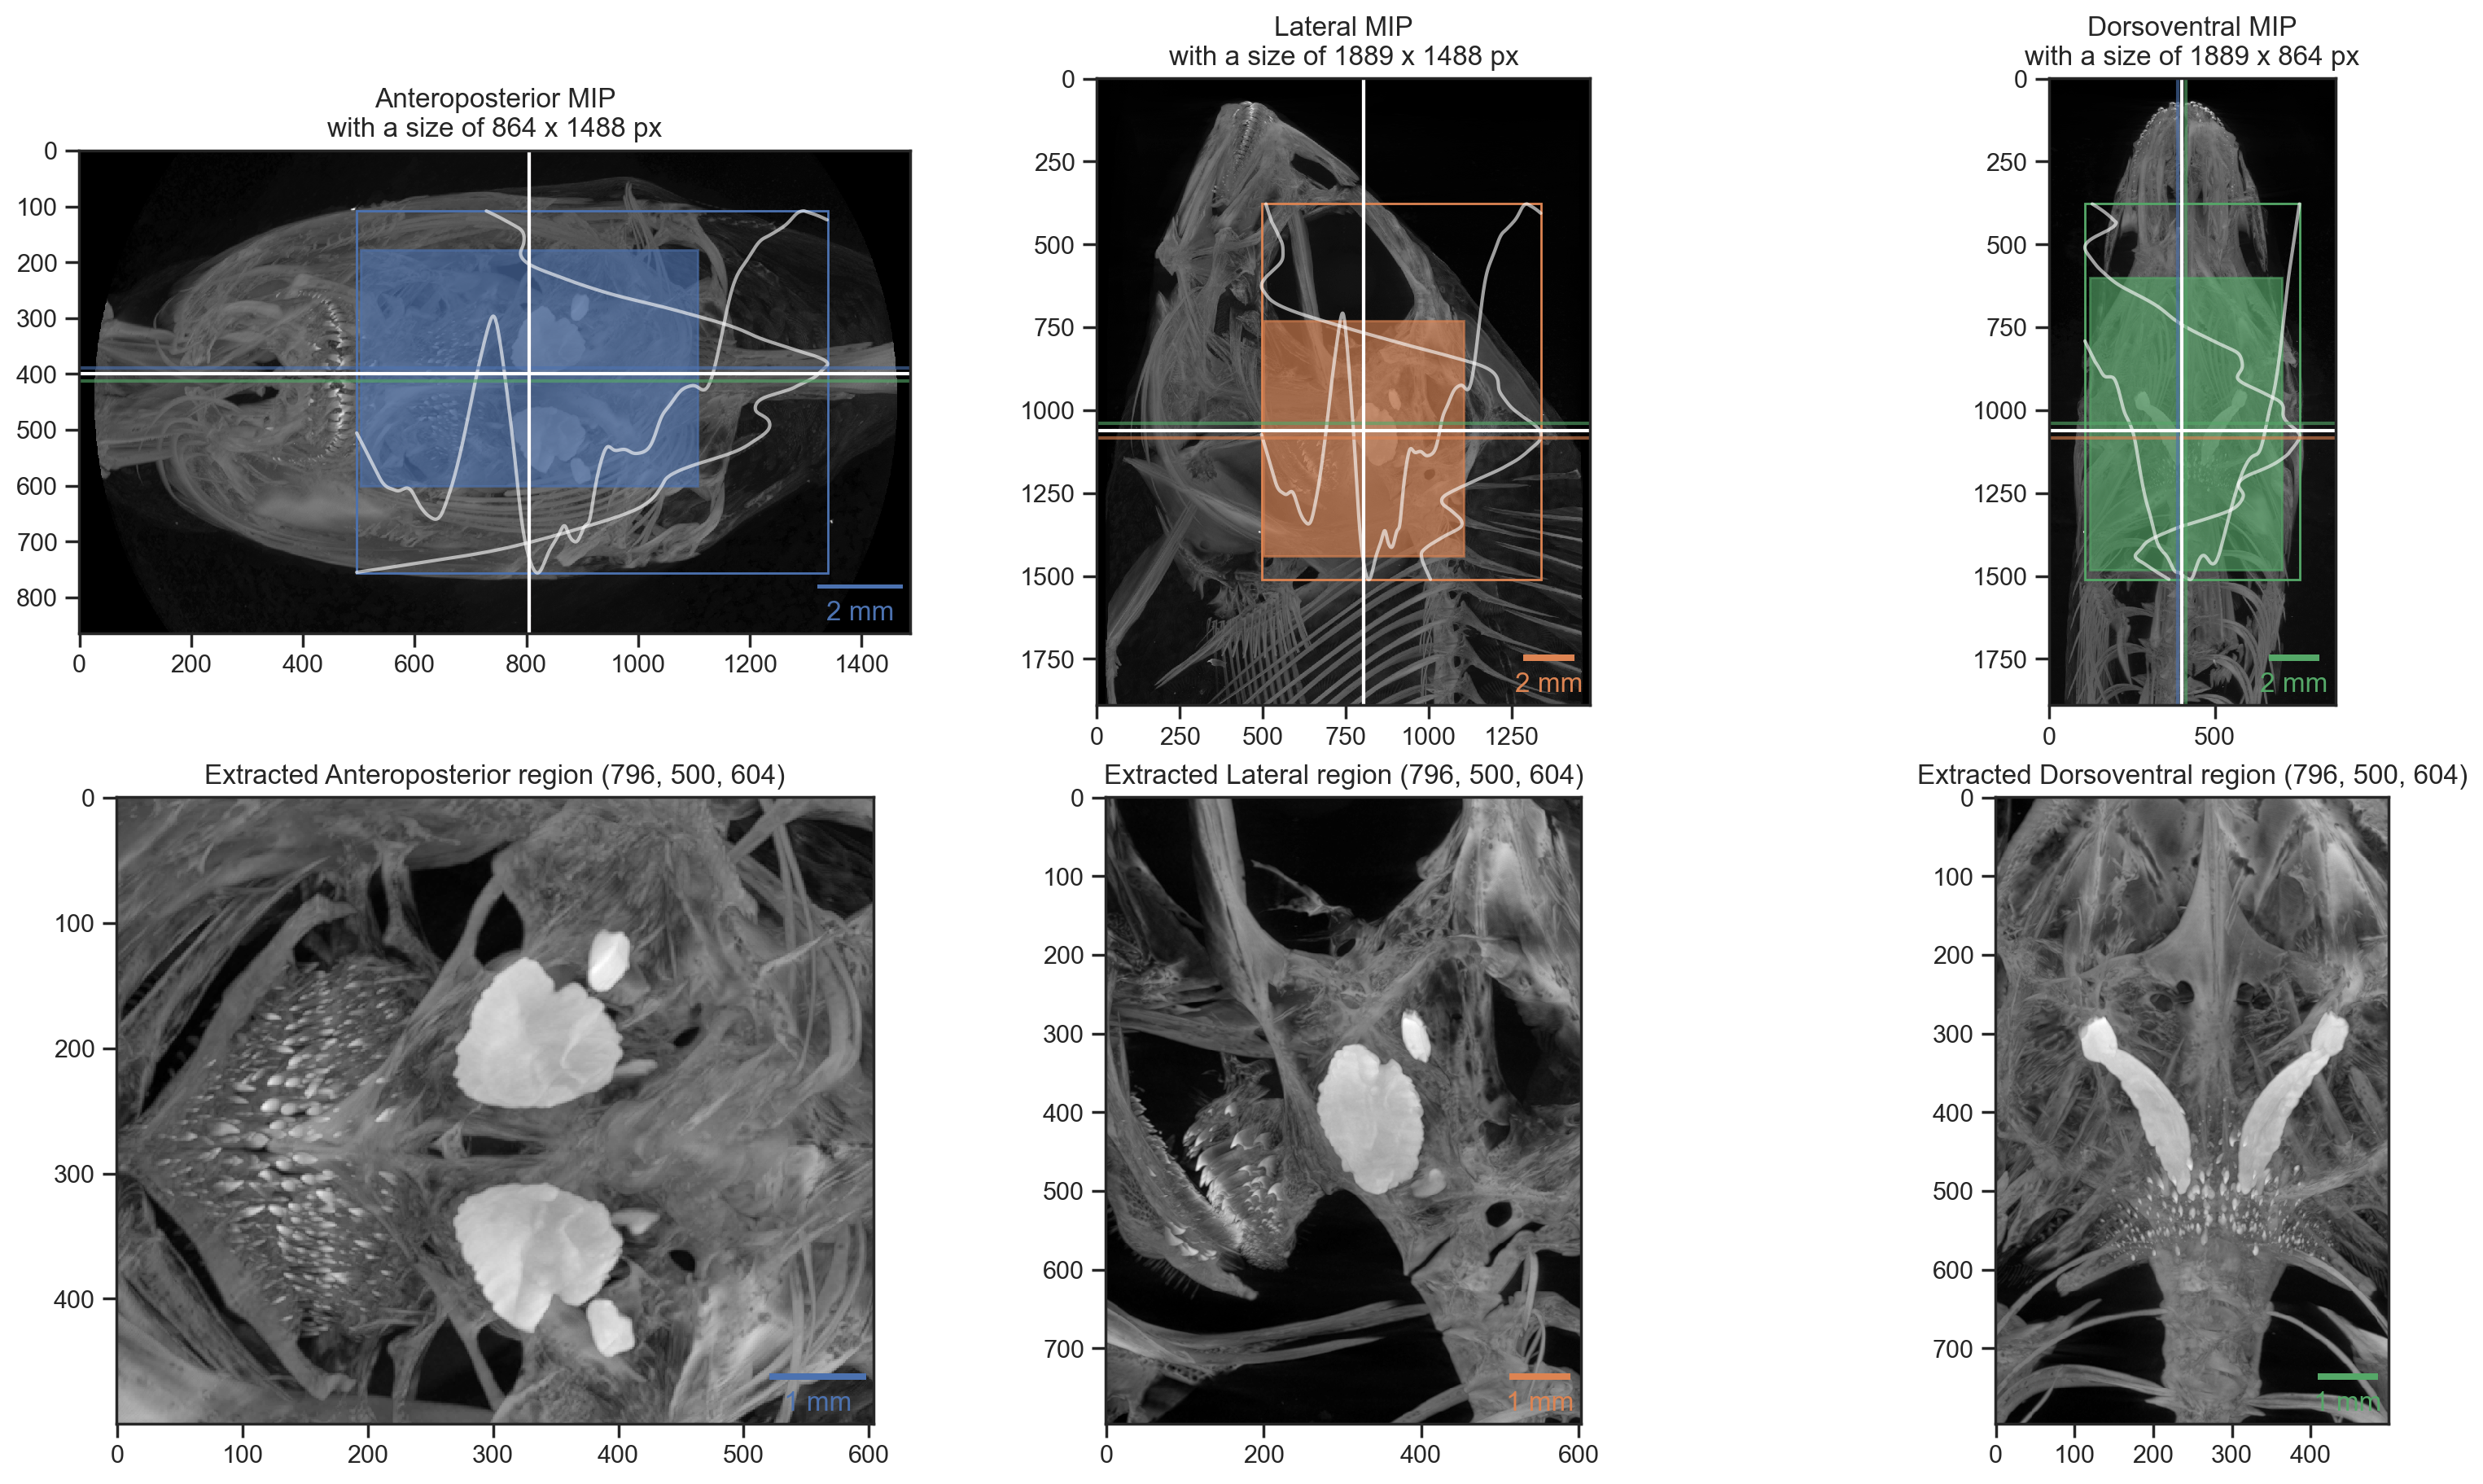

()

In [52]:
# Calculate and display otolith for one fish
display_otolith_position(whichone)

In [53]:
# Calculate otolith region for all fishes
for fishnumber, row in tqdm(Data.iterrows(),
                            desc='Extracting otolith regions',
                            total=len(Data)):
    otolither_region(fishnumber, verbose=False)

Extracting otolith regions:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
# items = 33
# for fishnumber, row in tqdm(Data.iterrows(),
#                             desc='Displaying otolith regions',
#                             total=len(Data)):
#     if fishnumber > items and fishnumber < items + 5:
#         print(80 * '-')
#         print(fishnumber, row.Fish, row.Scan)
#         display_otolith_position(fishnumber)

In [55]:
# Save out all otolith regions as .zarr files for quick access later
# Construct output file name
Data['OutputNameOtolithRegion'] = [os.path.join(os.path.dirname(folder), '%s.%s.Otolith.Region.zarr' % (fish, scan)) for folder, fish, scan in zip(Data['Folder'],
                                                                                                                                                   Data['Fish'],
                                                                                                                                                   Data['Scan'])]
# Replace otolith 'center' into name
Data['OutputNameOtolithRegion'] = [n.replace('.region', '.at.%04d.%04d.%04d' % (ap, lt, dv)) for (n, ap, lt, dv) in zip(Data['OutputNameOtolithRegion'],
                                                                                                                        Data['Otolith_Peak_Anteroposterior_fish'],
                                                                                                                        Data['Otolith_Peak_Lateral_fish'],
                                                                                                                        Data['Otolith_Peak_Dorsoventral_fish'])]
# Replace otlith width into name
Data['OutputNameOtolithRegion'] = [n.replace('.zarr', '.size.%04d.%04d.%04d.zarr' % (ap, lt, dv)) for (n, ap, lt, dv) in zip(Data['OutputNameOtolithRegion'],
                                                                                                                             Data['Otolith_Width_Anteroposterior_fish'],
                                                                                                                             Data['Otolith_Width_Lateral_fish'],
                                                                                                                             Data['Otolith_Width_Dorsoventral_fish'])]
# Actually save the regions out now
for fishnumber, row in tqdm(Data.iterrows(),
                            desc='Extracting otolith regions to .zarr files',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameOtolithRegion']):
        Reconstructions[fishnumber][Data['Otolith_Peak_Anteroposterior_fish'][fishnumber] - round(Data['Otolith_Width_Anteroposterior_fish'][fishnumber] / 2):
                                    Data['Otolith_Peak_Anteroposterior_fish'][fishnumber] + round(Data['Otolith_Width_Anteroposterior_fish'][fishnumber] / 2),
                                    Data['Otolith_Peak_Lateral_fish'][fishnumber] - round(Data['Otolith_Width_Lateral_fish'][fishnumber] / 2):
                                    Data['Otolith_Peak_Lateral_fish'][fishnumber] + round(Data['Otolith_Width_Lateral_fish'][fishnumber] / 2),
                                    Data['Otolith_Peak_Dorsoventral_fish'][fishnumber] - round(Data['Otolith_Width_Dorsoventral_fish'][fishnumber] / 2):
                                    Data['Otolith_Peak_Dorsoventral_fish'][fishnumber] + round(Data['Otolith_Width_Dorsoventral_fish'][fishnumber] / 2)].rechunk('auto').to_zarr(row['OutputNameOtolithRegion'],
                                                                                                                                                                                 overwrite=True,
                                                                                                                                                                                 compressor=Blosc(cname='zstd',
                                                                                                                                                                                 shuffle=Blosc.BITSHUFFLE))

Extracting otolith regions to .zarr files:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
# Load the saved out otolith regions again
Otoliths = [dask.array.from_zarr(file) for file in Data['OutputNameOtolithRegion']]

Now that we calculated everything, we can display it for *one* fish for the manuscript

In [57]:
# Search and use one specific fish
print('The fish we are looking for is item %s in our dataframe' % whichone)
print('We are loading the extracted otolith region of %s' % os.path.join(Data.Fish[whichone], Data.Scan[whichone]))

The fish we are looking for is item 0 in our dataframe
We are loading the extracted otolith region of 104016\head.rec


In [58]:
# Put extracted otolith into a variable for simpler handling
otolith = Otoliths[whichone]

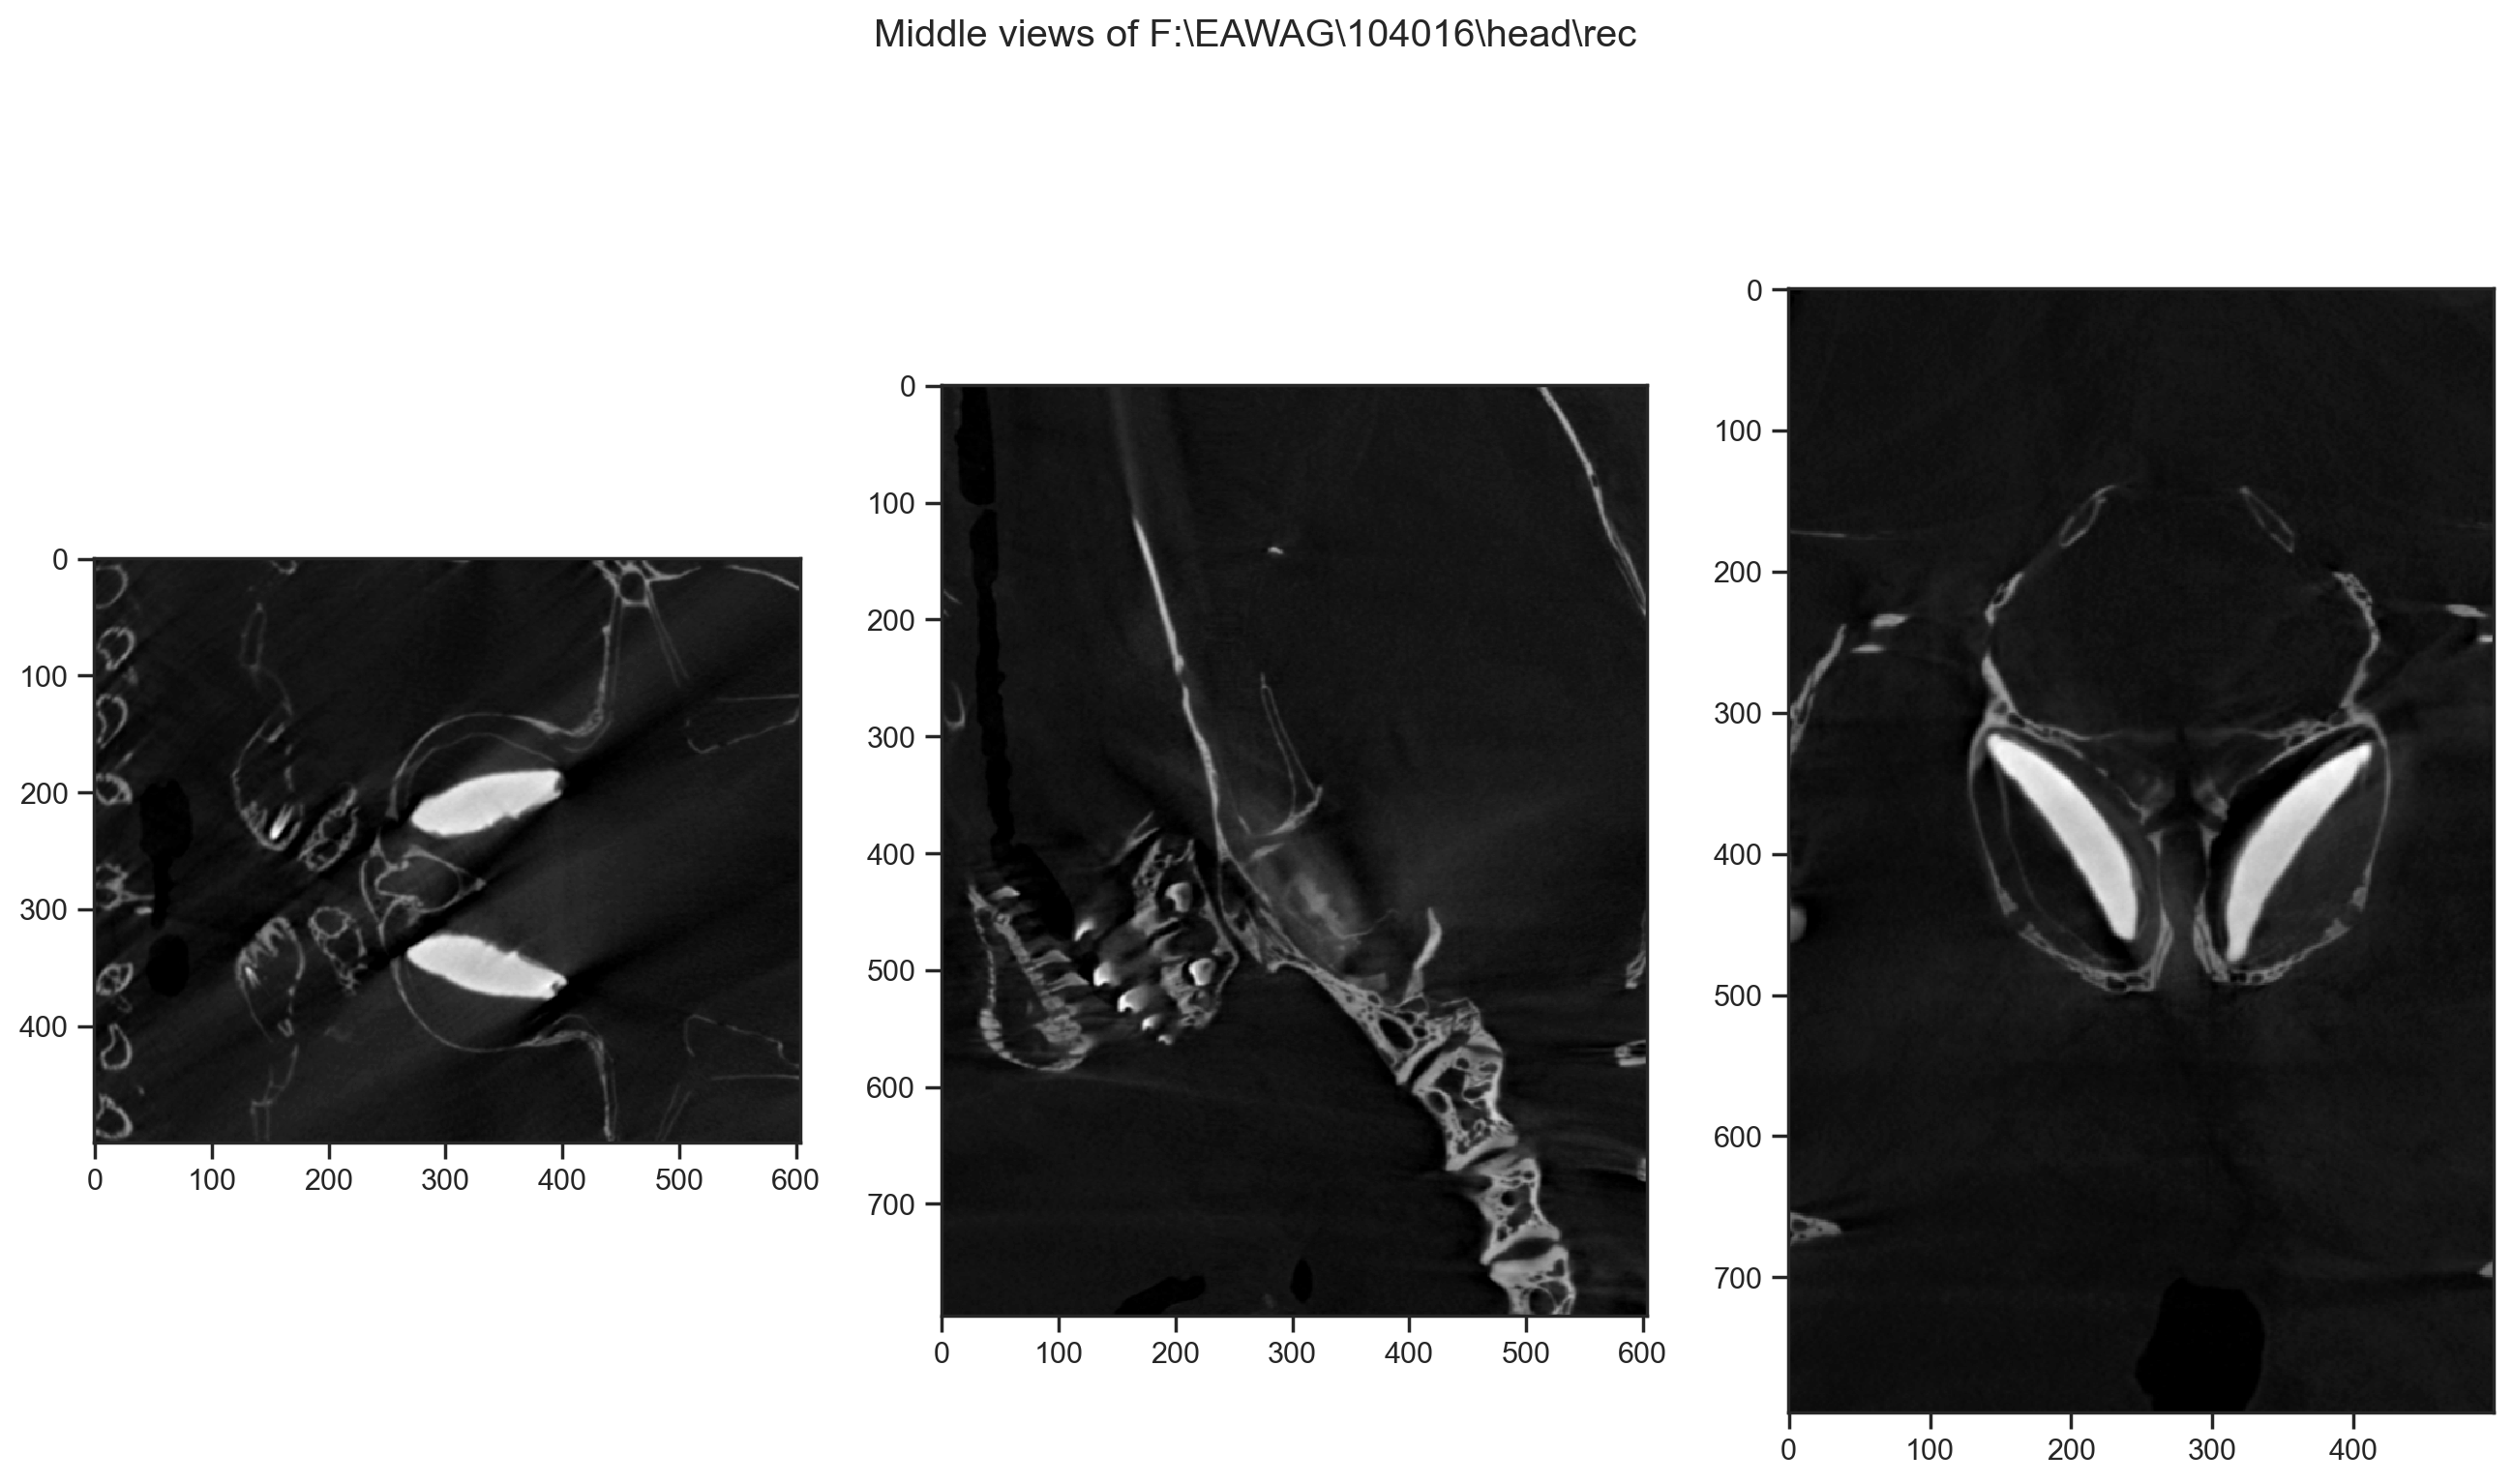

In [59]:
# Show central views
plt.subplot(131)
plt.imshow(otolith[otolith.shape[0] // 2, :, :])
plt.subplot(132)
plt.imshow(otolith[:, otolith.shape[1] // 2, :])
plt.subplot(133)
plt.imshow(otolith[:, :, otolith.shape[2] // 2])
plt.suptitle('Middle views of %s' % Data['Folder'][whichone])
plt.show()

In [60]:
# Compute histogram
histogram, bins = dask.array.histogram(otolith[otolith > 0], bins=2**8, range=(0, 2**8))

In [61]:
# Compute us some (multiotsu) peaks
peaks = skimage.filters.threshold_multiotsu(otolith.compute(), classes=5)

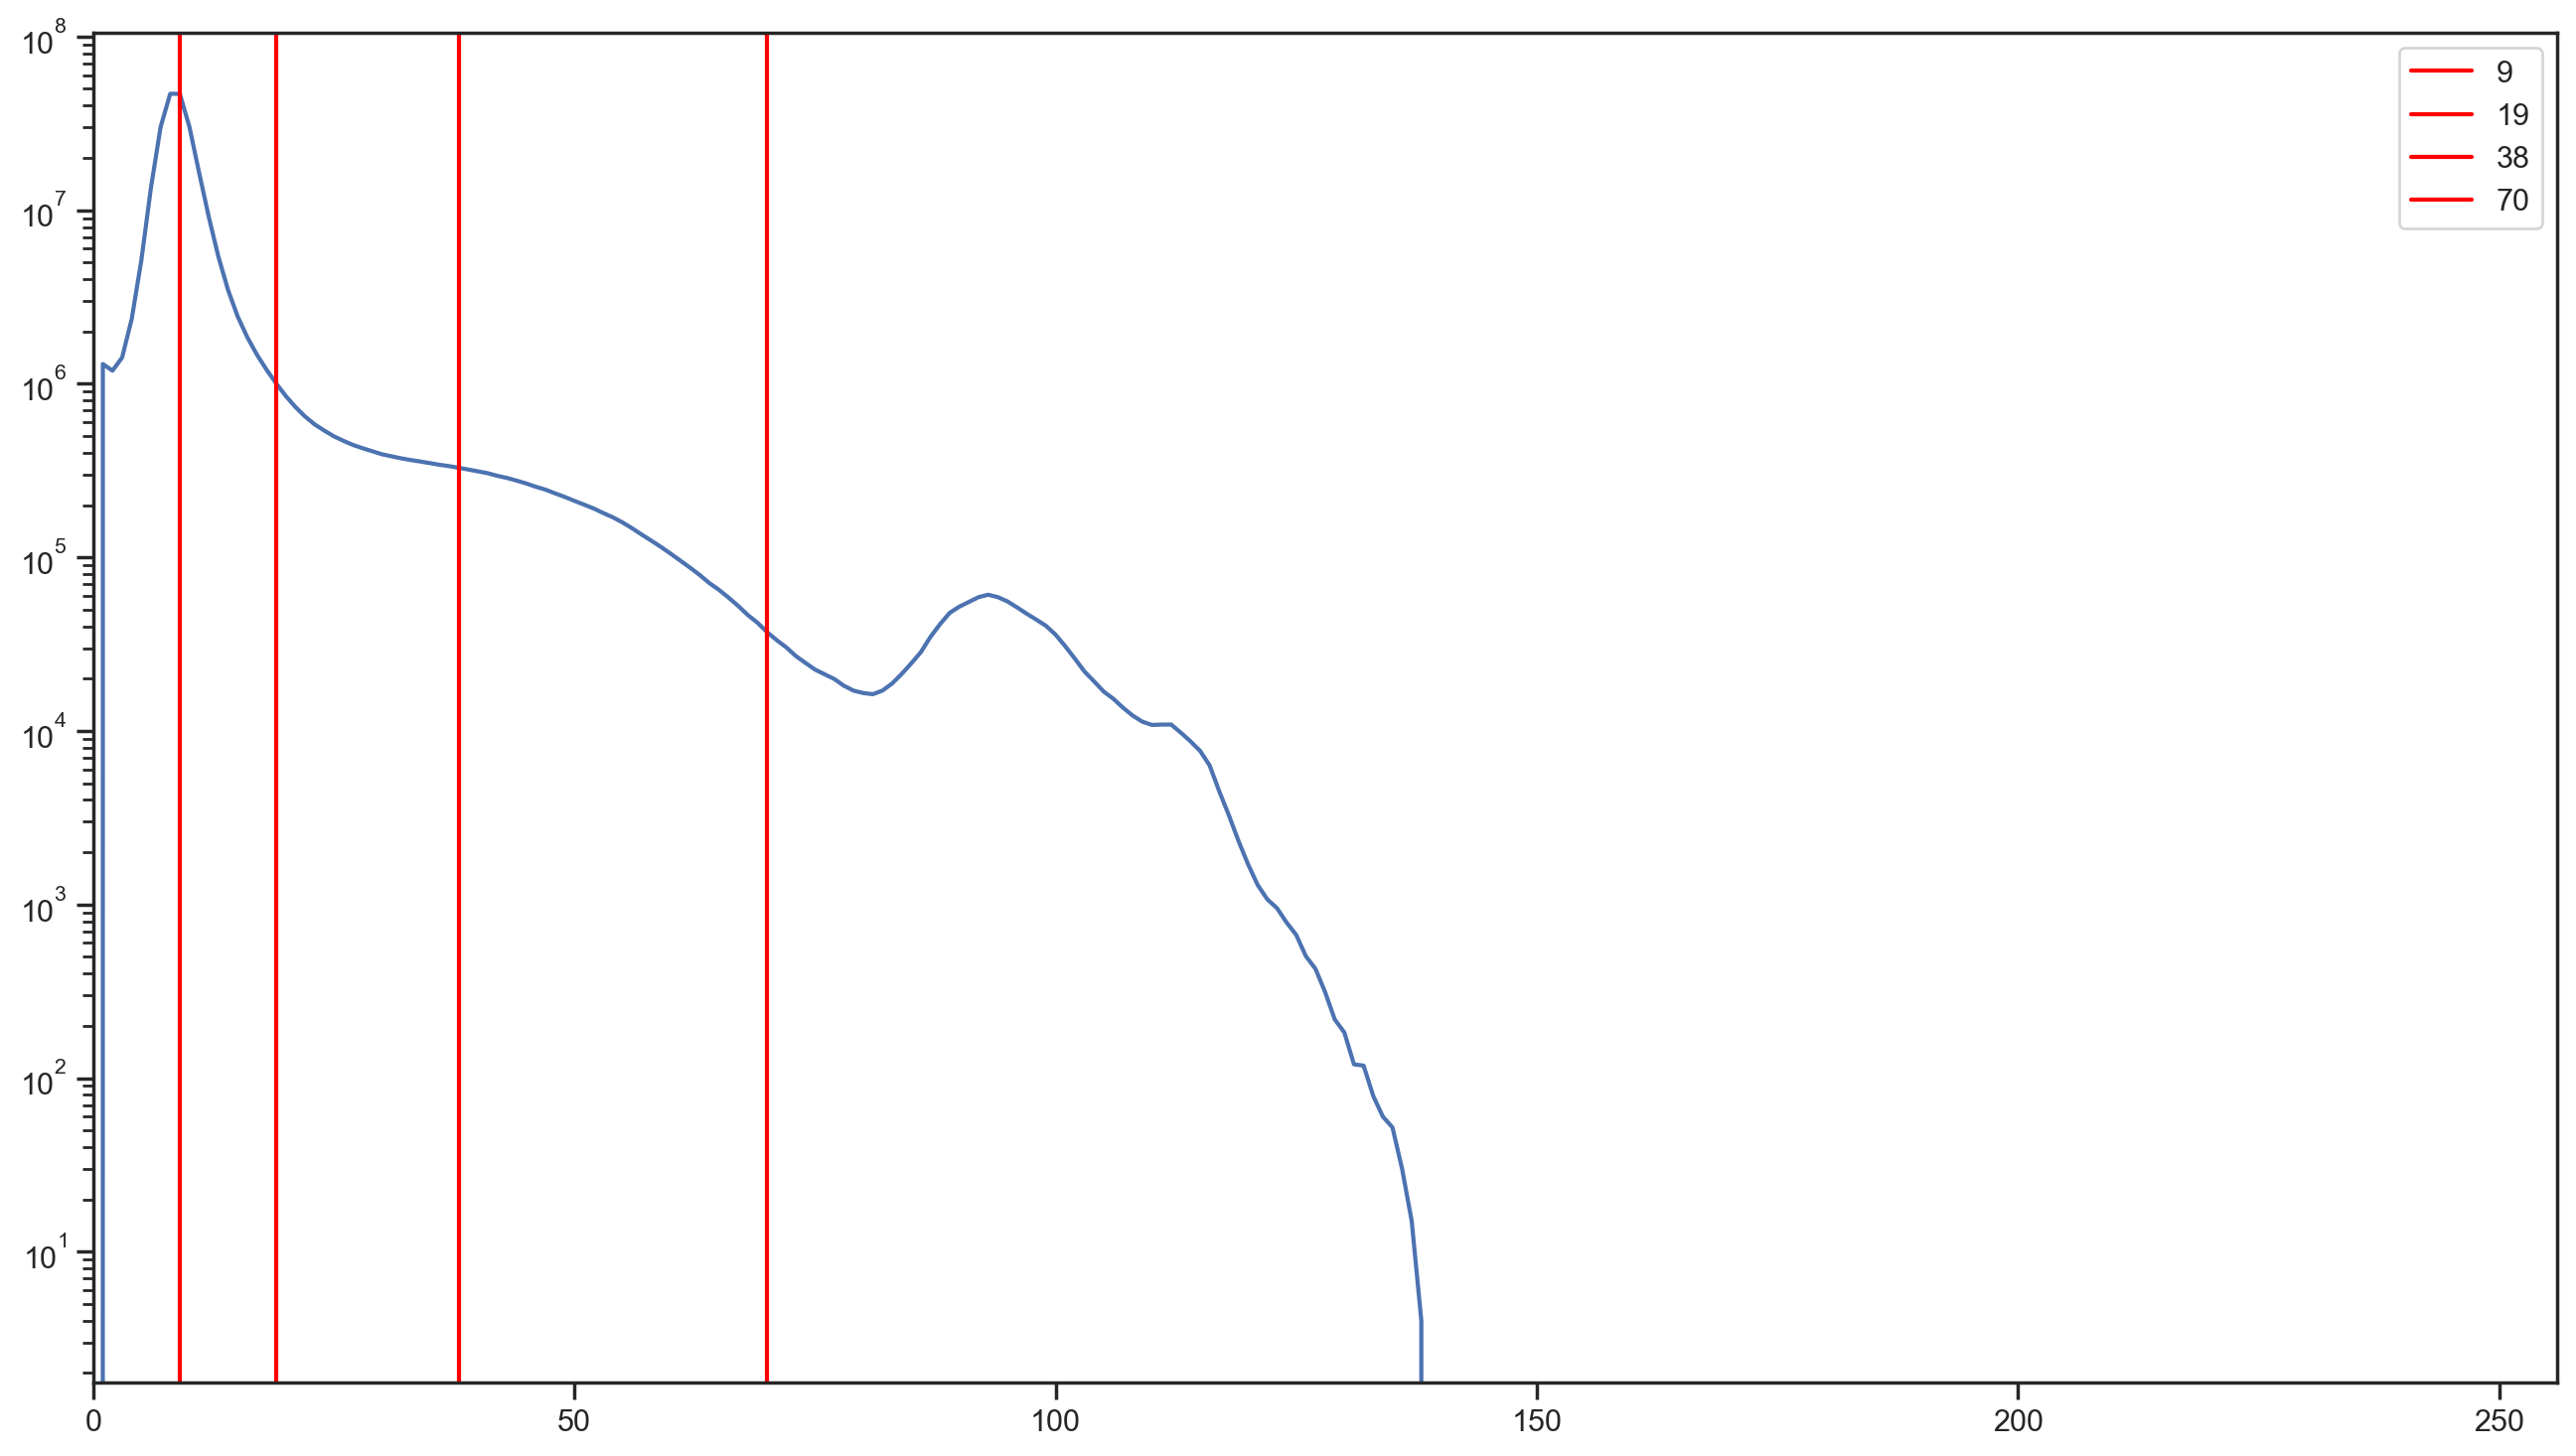

In [62]:
# Plot histogram and overlay the peaks
plt.semilogy(histogram)
# Show multiotsu threshold
for peak in peaks:
    plt.axvline(peak, label=peak, c='red')
plt.xlim([0, 2**8])
plt.legend()
plt.show()

Figure saved to F:\EAWAG\104016\head\104016.head.rec.Otolith.Region.MIP.png


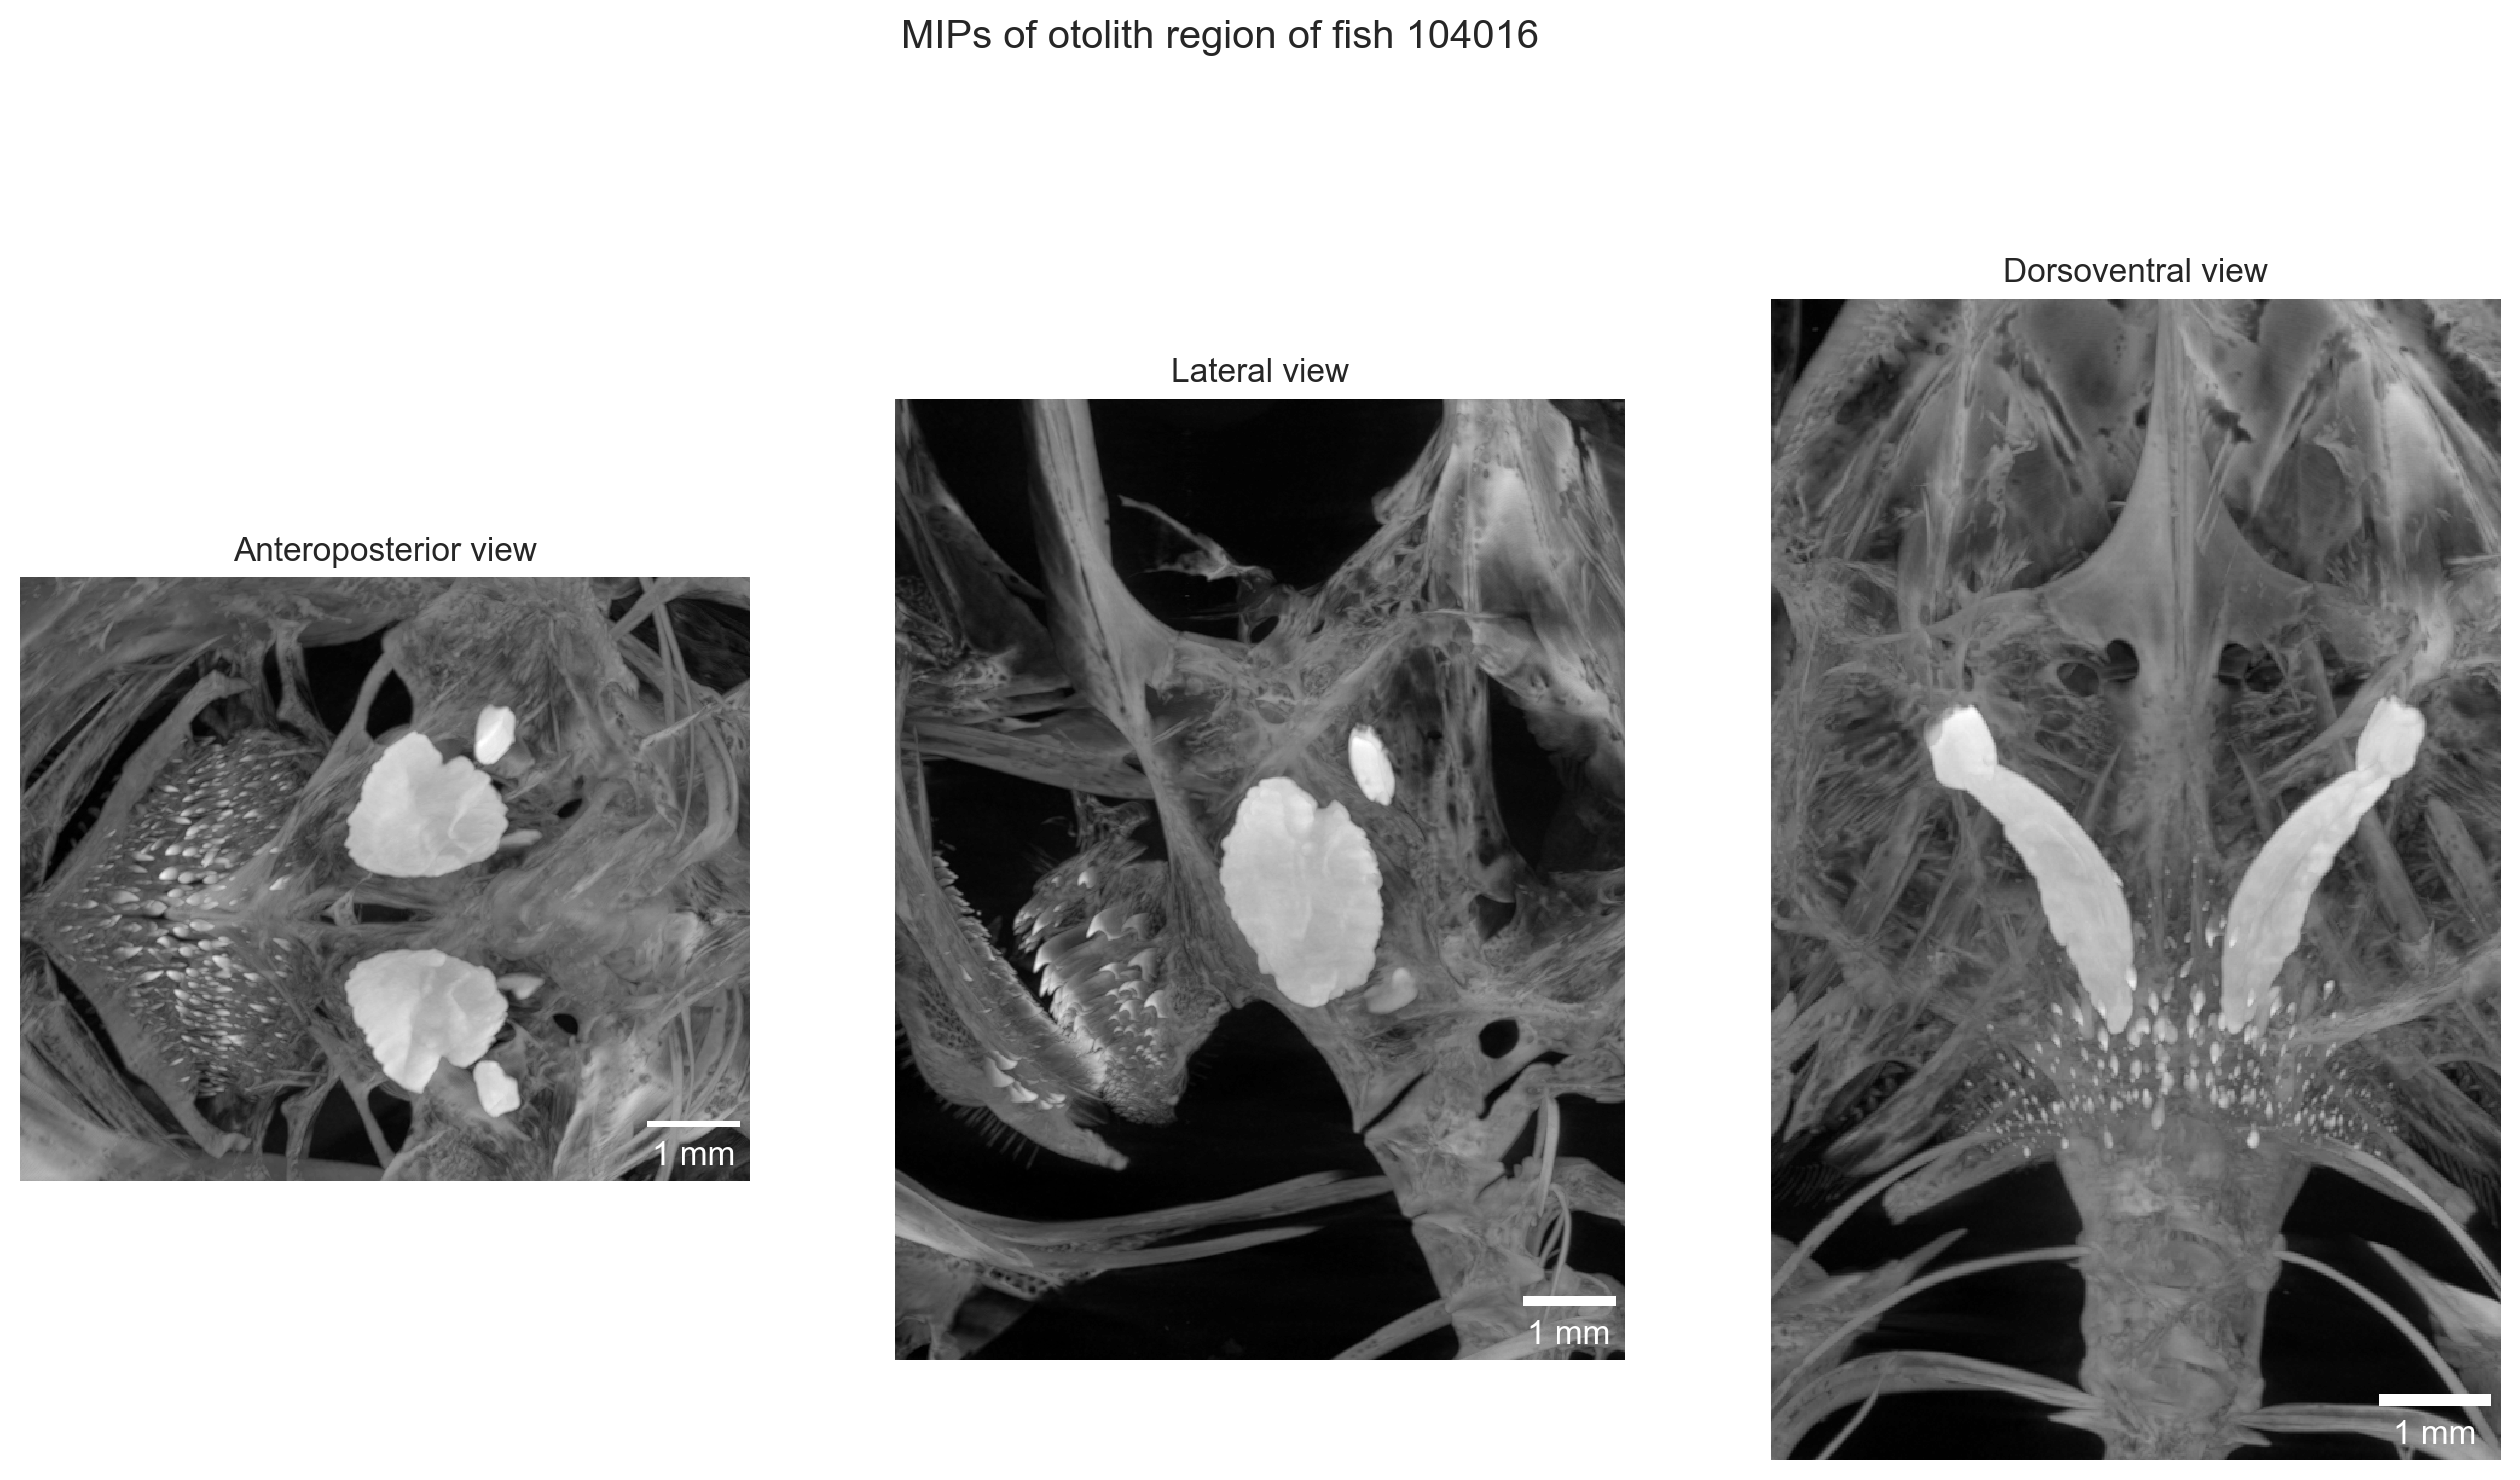

In [63]:
# Display MIP view of extracted otolith region *in* original data
outputname = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                          '%s.%s.Otolith.Region.MIP.png' % (Data['Fish'][whichone], Data['Scan'][whichone]))
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c + 1)
    plt.imshow(otolith.max(axis=c))
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(Data.Voxelsize[whichone], 'um'))
    plt.title('%s view' % direction)
plt.suptitle('MIPs of otolith region of fish %s' % Data['Fish'][whichone])
if not os.path.exists(outputname):
    plt.savefig(outputname,
                transparent=True,
                bbox_inches='tight')
    print('Figure saved to %s' % outputname)
plt.show()

In [64]:
def get_largest_regions(segmentation, number_of_regions=4, verbose=False):
    # Get out biggest item from image
    # First iteration based on https://stackoverflow.com/a/55110923/323100
    # Since we want to select the several largest items, we improved on it basedd on
    # https://github.com/numpy/numpy/issues/15128 and
    # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array#comment24252527_6910672
    labels = skimage.measure.label(segmentation)
    # print(numpy.argsort(-numpy.bincount(labels.flat, weights=labels.flat))[:number_of_regions])
    # print(sorted(numpy.bincount(labels.flat, weights=labels.flat), reverse=True)[:number_of_regions])
    # print(numpy.argmax(numpy.bincount(labels.flat, weights=labels.flat)))
    # Initialize empty array to add into
    largestCC = dask.array.zeros_like(segmentation)
    for lbl in numpy.argsort(-numpy.bincount(labels.flat, weights=labels.flat))[:number_of_regions]:
        largestCC += labels == lbl
    if verbose:
        plt.subplot(121)
        plt.imshow(segmentation)
        plt.subplot(122)
        plt.imshow(largestCC)
        plt.suptitle('Largest connected component')
        plt.show()
    return dask.array.rechunk(largestCC.astype('uint8'))

In [65]:
# Get out largest regions
largest = get_largest_regions((otolith > peaks[-1]), number_of_regions=4)

In [66]:
# Use the largest regions as masks for the original data
masked = dask.array.multiply(otolith, largest)

In [67]:
masked

dask.array<multiply, shape=(796, 500, 604), dtype=uint8, chunksize=(398, 500, 604), chunktype=numpy.ndarray>

In [68]:
def trim_zeros(arr):
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    From https://stackoverflow.com/a/65547931/323100
    """
    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in numpy.nonzero(arr))
    return arr[slices]

In [69]:
# Trim the masked data
masked_trimmed = dask.array.asarray(trim_zeros(masked.compute()))

In [70]:
masked_trimmed

dask.array<array, shape=(235, 343, 146), dtype=uint8, chunksize=(235, 343, 146), chunktype=numpy.ndarray>

Figure saved to F:\EAWAG\104016\head\104016.head.rec.Otolith.Region.extracted.MIP.png


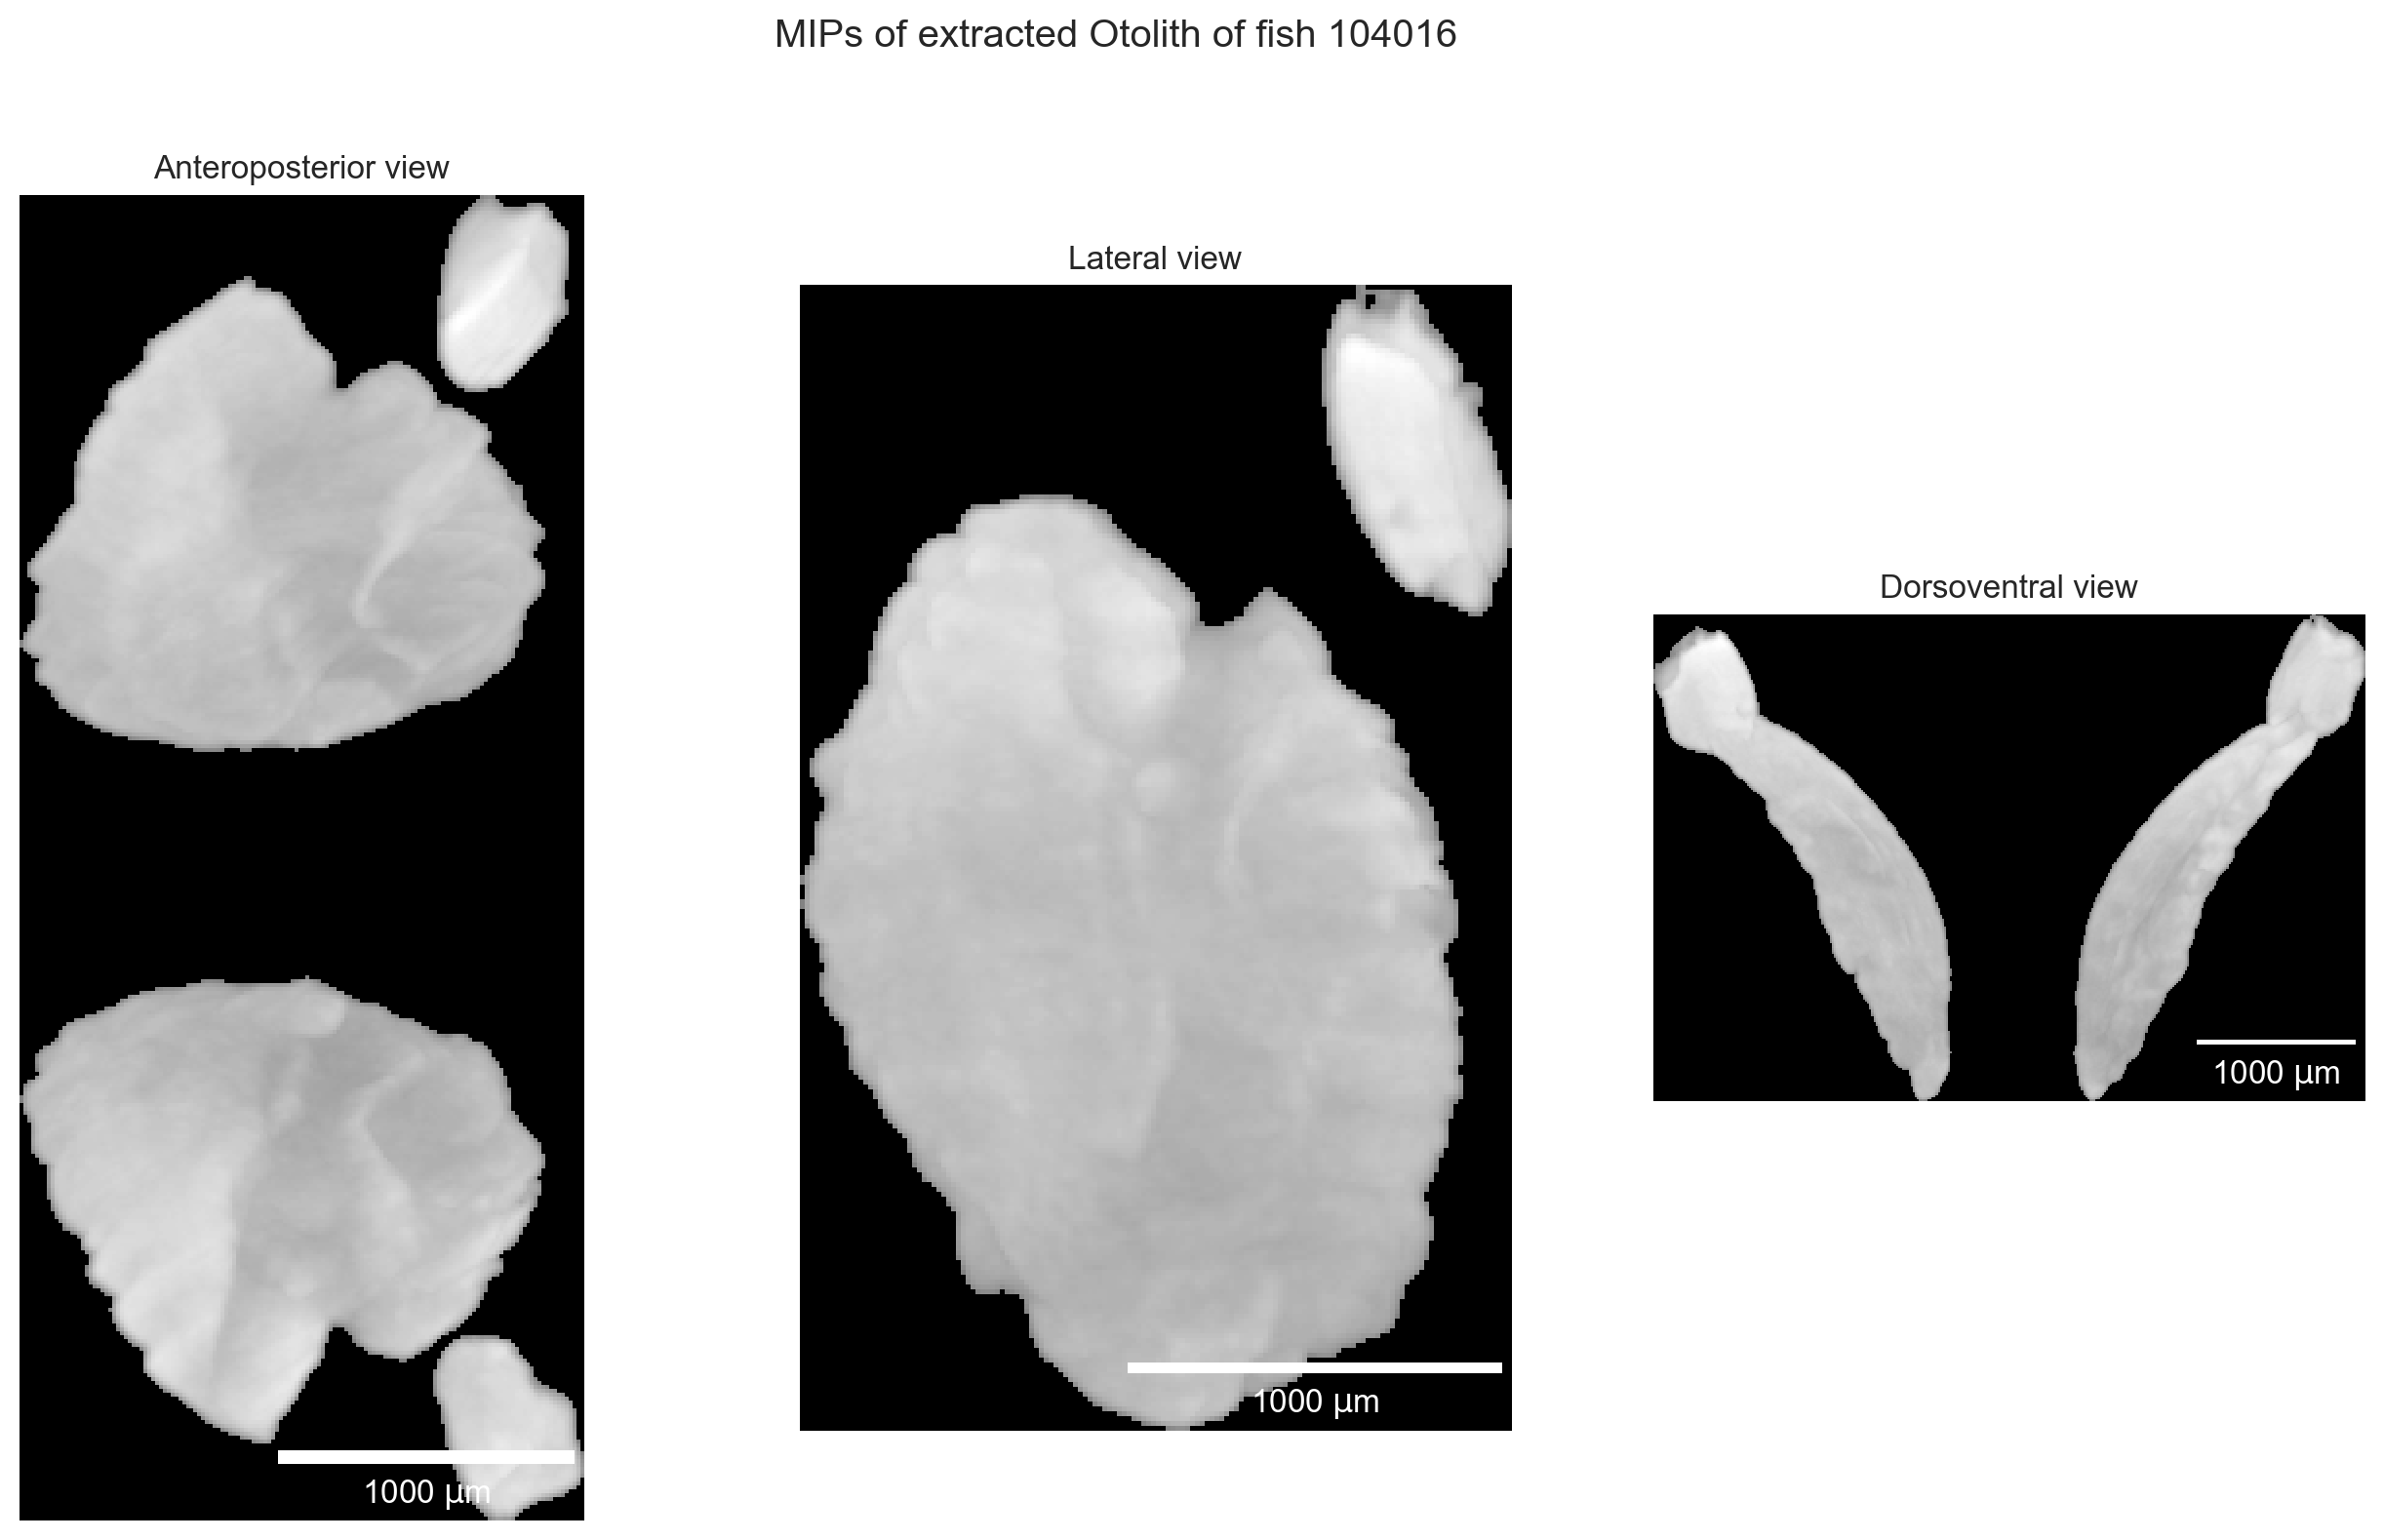

In [71]:
# Display MIP of extracted and masked otolith region
outputname = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                          '%s.%s.Otolith.Region.extracted.MIP.png' % (Data['Fish'][whichone], Data['Scan'][whichone]))
for c, direction in enumerate(directions):
    plt.subplot(1, 3, c + 1)
    plt.imshow(masked_trimmed.max(axis=c))
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(Data.Voxelsize[whichone], 'um', fixed_value=1000))
    plt.title('%s view' % direction)
plt.suptitle('MIPs of extracted Otolith of fish %s' % Data['Fish'][whichone])
if not os.path.exists(outputname):
    plt.savefig(outputname,
                transparent=True,
                bbox_inches='tight')
    print('Figure saved to %s' % outputname)
plt.show()

In [72]:
for s in masked_trimmed.shape:
    print(round(s*Data.Voxelsize[whichone]/1000,1), 'mm')

3.1 mm
4.5 mm
1.9 mm


View the otolith in 3D

In [83]:
# Display the largestCC of the otolith in 3D
subsample = 1
masked_trimmed_volume = k3d.volume(masked_trimmed[::subsample, ::subsample, ::subsample].astype(numpy.float16),
                                   bounds = [0, Data.Voxelsize[whichone] * masked_trimmed.shape[0] / 1000,
                                             0, Data.Voxelsize[whichone] * masked_trimmed.shape[1] / 1000,
                                             0, Data.Voxelsize[whichone] * masked_trimmed.shape[2] / 1000])
plot = k3d.plot()
plot += masked_trimmed_volume
plot.display()

Output()

In [88]:
# Set nice view above and save camera state
# https://github.com/K3D-tools/K3D-jupyter/issues/417
plot.camera

[-0.023905280637010362,
 -2.5560382238791846,
 -1.8080819209806491,
 1.5276702642440796,
 2.229748487472534,
 0.9491057991981506,
 0.11833946447558473,
 0.574875775962078,
 -0.80963795202522]

In [89]:
# Save out HTML page, once in the subdirectory of the fish/scan, and
outputname = os.path.join(os.path.dirname(Data['Folder'][whichone]),
                          '%s.%s.Otolith.Region.3D.html' % (Data['Fish'][whichone], Data['Scan'][whichone]))
if not os.path.exists(outputname):
    with open(outputname, "w") as f:
        plot.camera = [-0.023905280637010362,
                       -2.5560382238791846,
                       -1.8080819209806491,
                       1.5276702642440796,
                       2.229748487472534,
                       0.9491057991981506,
                       0.11833946447558473,
                       0.574875775962078,
                       -0.80963795202522]
        f.write(plot.get_snapshot())
    print('3D view saved to %s' % outputname)
else:
    print('3D view was already saved to %s, not saving it again' % outputname)

3D view saved to F:\EAWAG\104016\head\104016.head.rec.Otolith.Region.3D.html


In [75]:
# Save out HTML page, once in the 'manuscript' directory for using as supplementary material
outputname_SM = os.path.join('manuscript', 'content', 'data',
                             '%s.%s.Otolith.Region.3D.html' % (Data['Fish'][whichone], Data['Scan'][whichone]))    
with open(outputname_SM, "w") as f:
        f.write(plot.get_snapshot())    

In [76]:
# # Do the extraction dance for all the fishes
# for fishnumber, row in tqdm(Data.iterrows(),
#                             desc='Displaying otolith regions and stuff',
#                             total=len(Data)):
#     outputnameMIP = os.path.join(os.path.dirname(Data['Folder'][fishnumber]), Data['Fish'][fishnumber] + '.Otolith.Region.MIP.png')
#     outputnameTrimmedMIP = os.path.join(os.path.dirname(Data['Folder'][fishnumber]), Data['Fish'][fishnumber] + '.Otolith.Region.Extracted.MIP.png')
#     o = Otoliths[fishnumber]
#     h, b = dask.array.histogram(o[o > 0], bins=2**8, range=(0, 2**8))
#     peaks = skimage.filters.threshold_multiotsu(o.compute(), classes=5)
#     if not os.path.exists(outputnameMIP):
#         # Display MIP view of extracted otolith region *in* original data
#         for c, direction in enumerate(directions):
#             plt.subplot(1, 3, c + 1)
#             plt.imshow(o.max(axis=c))
#             plt.axis('off')
#             plt.gca().add_artist(ScaleBar(Data.Voxelsize[fishnumber], 'um'))
#             plt.title('%s view' % direction)
#         plt.suptitle('MIPs of otolith region of fish %s' % Data['Fish'][fishnumber])
#         plt.savefig(outputnameMIP,
#                     transparent=True,
#                     bbox_inches='tight')
#         print('Figure saved to %s' % outputnameMIP)
#         plt.show()
#     if not os.path.exists(outputnameTrimmedMIP):
#         # Get out largest regions
#         try:
#             l = get_largest_regions((o>peaks[-1]), number_of_regions=4)
#         except MemoryError:
#             print('Could not label region, probably too big')
#             l = dask.array.zeros_like(o)
#             l[100:-100,100:-100,100:-100] = o[100:-100,100:-100,100:-100]
#         masked = dask.array.multiply(o, l)
#         masked_trimmed = dask.array.asarray(trim_zeros(masked.compute()))
#         # Display MIP of extracted and masked otolith region
#         for c, direction in enumerate(directions):
#             plt.subplot(1, 3, c + 1)
#             plt.imshow(masked_trimmed.max(axis=c))
#             plt.axis('off')
#             plt.gca().add_artist(ScaleBar(Data.Voxelsize[fishnumber], 'um'))
#             plt.title('%s view' % direction)
#         plt.suptitle('MIPs of extracted Otolith of fish %s' % Data['Fish'][fishnumber])
#         plt.savefig(outputnameTrimmedMIP,
#                     transparent=True,
#                     bbox_inches='tight')
#         print('Figure saved to %s' % outputnameTrimmedMIP)
#         plt.show()